In [1]:
import os, glob, numpy as np, pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [25, 15]
plt.rcParams.update({'font.size': 18})
import time

In [2]:
def load_dataframe_from_files(dirin, fileprefix, max_files=100):
    import glob
    files = glob.glob(os.path.join(dirin, fileprefix))
    print("[Info] Loading {} files wt prefix:\n{}".format(len(files), fileprefix))
    df = pd.read_csv(files[0], comment='#', index_col=False)
    for file in files[1:max_files]:
        print(".", end='')
        dftmp = pd.read_csv(file, comment='#', index_col=False)
        df = pd.concat([df, dftmp])
    print("")
    return df

In [3]:
init = time.time()
dirin = os.path.join("..", "Data", "OutputProcessing", "Neutrons_Cut1000mm_09_04_2020", "Neutrons_Snapshots")

fileinprefix = "SnapshotAr41*.csv"
df_ar41 = load_dataframe_from_files(dirin, fileinprefix)
df_ar41 = df_ar41[df_ar41.columns[:-1]]

print("[Info] Loaded data in {:.3f} seconds".format(time.time() - init))

[Info] Loading 1 files wt prefix:
SnapshotAr41*.csv

[Info] Loaded data in 0.043 seconds


In [4]:
init = time.time()
dirin = os.path.join("..", "Data", "OutputProcessing", "Ar39_08_18_2020", "Ar39_Snapshots")

fileinprefix = "Snapshot1Ar39*.csv"
df_ar39 = load_dataframe_from_files(dirin, fileinprefix)
df_ar39 = df_ar39[df_ar39.columns[:-1]]

print("[Info] Loaded data in {:.3f} seconds".format(time.time() - init))

[Info] Loading 100 files wt prefix:
Snapshot1Ar39*.csv
...................................................................................................
[Info] Loaded data in 58.177 seconds


# select data

In [9]:
min_pe, max_pe = 5, 50
cutar39 = df_ar39[(df_ar39.pedetected>=min_pe) & (df_ar39.pedetected<=max_pe)]
cutar41 = df_ar41[(df_ar41.pedetected>=min_pe) & (df_ar41.pedetected<=max_pe)]
print("[Info] Ar39: original events: {}, selected events: {}".format(len(df_ar39), len(cutar39)))
print("[Info] Ar41: original events: {}, selected events: {}".format(len(df_ar41), len(cutar41)))

[Info] Ar39: original events: 5303515, selected events: 461921
[Info] Ar41: original events: 11733, selected events: 7203


In [10]:
# remove test data from ar41
n_test_ar41 = round(.10 * len(cutar41))
id_ar41 = np.arange(len(cutar41))
np.random.shuffle(id_ar41)
test_ar41, train_ar41 = cutar41.iloc[id_ar41[:n_test_ar41], :], cutar41.iloc[id_ar41[n_test_ar41:], :]

# augment ar41 data by rolling

In [11]:
import warnings
def augment_muons_by_roll(muon_df, n_inner_slices=12, n_outer_slices=20, n_inner_roll=3, n_outer_roll=5):
    X_inner = muon_df.iloc[:, :n_inner_slices].to_numpy()
    X_outer = muon_df.iloc[:, n_inner_slices:n_inner_slices+n_outer_slices].to_numpy()
    if not n_inner_slices/n_inner_roll == n_outer_slices/n_outer_roll:
        warnings("[Warning] The inner/outer rolls are not consistent. Break.")
        return
    n_rolls = int(n_inner_slices / n_inner_roll)
    for roll in np.array(np.linspace(0, n_inner_slices, n_rolls+1)[:-1], dtype='int'):
        if roll==0:
            XX_inner = X_inner
        else:
            XX_inner = np.concatenate([XX_inner, np.roll(X_inner, roll, axis=1)])
    for roll in np.array(np.linspace(0, n_outer_slices, n_rolls+1)[:-1], dtype='int'):
        if roll==0:
            XX_outer = X_outer
        else:
            XX_outer = np.concatenate([XX_outer, np.roll(X_outer, roll, axis=1)])
    return pd.DataFrame(np.concatenate([XX_inner, XX_outer], axis=1))

In [79]:
aug_ar41_train = augment_muons_by_roll(train_ar41.iloc[:, 3:])
#aug_ar41_train = pd.DataFrame(train_ar41.iloc[:, 3:].to_numpy())
print("[Info] Augmented Ar41 Data: {} instances".format(len(aug_ar41_train)))

[Info] Augmented Ar41 Data: 25932 instances


# undersample ar39

In [13]:
def undersample_argon(ar39_df, number_of_instances=1000, augment_from_pe=35, augmentation_nr=5,
                      skip_first_cols=2, nslices=72):
    bins = np.linspace(0, ar39_df.pedetected.max()+1, ar39_df.pedetected.max()+2)
    bin_cont, bin_edges, _ = plt.hist(ar39_df.pedetected, bins=bins, density=True, label="Ar39", edgecolor='w')
    # compute the nr of samples for each PE value,
    # to undersample ar39 keeping the same distribution
    avail_instances_per_pe = np.array([len(ar39_df[ar39_df.pedetected==pe]) for pe in range(0, ar39_df.pedetected.max()+1)])
    nr_ar_samples_per_pe = np.array(np.where(np.ceil(bin_cont*number_of_instances)<=avail_instances_per_pe, np.ceil(bin_cont*number_of_instances), number_of_instances), dtype=int)
    # Introduce a small bias on instances with "high" PE value
    # to avoid to have just a few samples (e.g. 30,40,50,60 PE)
    scaled_ar39 = pd.DataFrame()
    for pe in range(1, ar39_df.pedetected.max()+1):
        if pe > augment_from_pe:
            nr_instances = augmentation_nr
        else:
            nr_instances = nr_ar_samples_per_pe[pe]
        scaled_ar39 = pd.concat([scaled_ar39, ar39_df[ar39_df.pedetected==pe].iloc[:nr_instances]])
    AA = scaled_ar39.iloc[:, skip_first_cols:skip_first_cols+nslices].to_numpy()
    np.random.shuffle(AA)    # to avoid order by PE
    return pd.DataFrame(AA)

2.5569939613342285


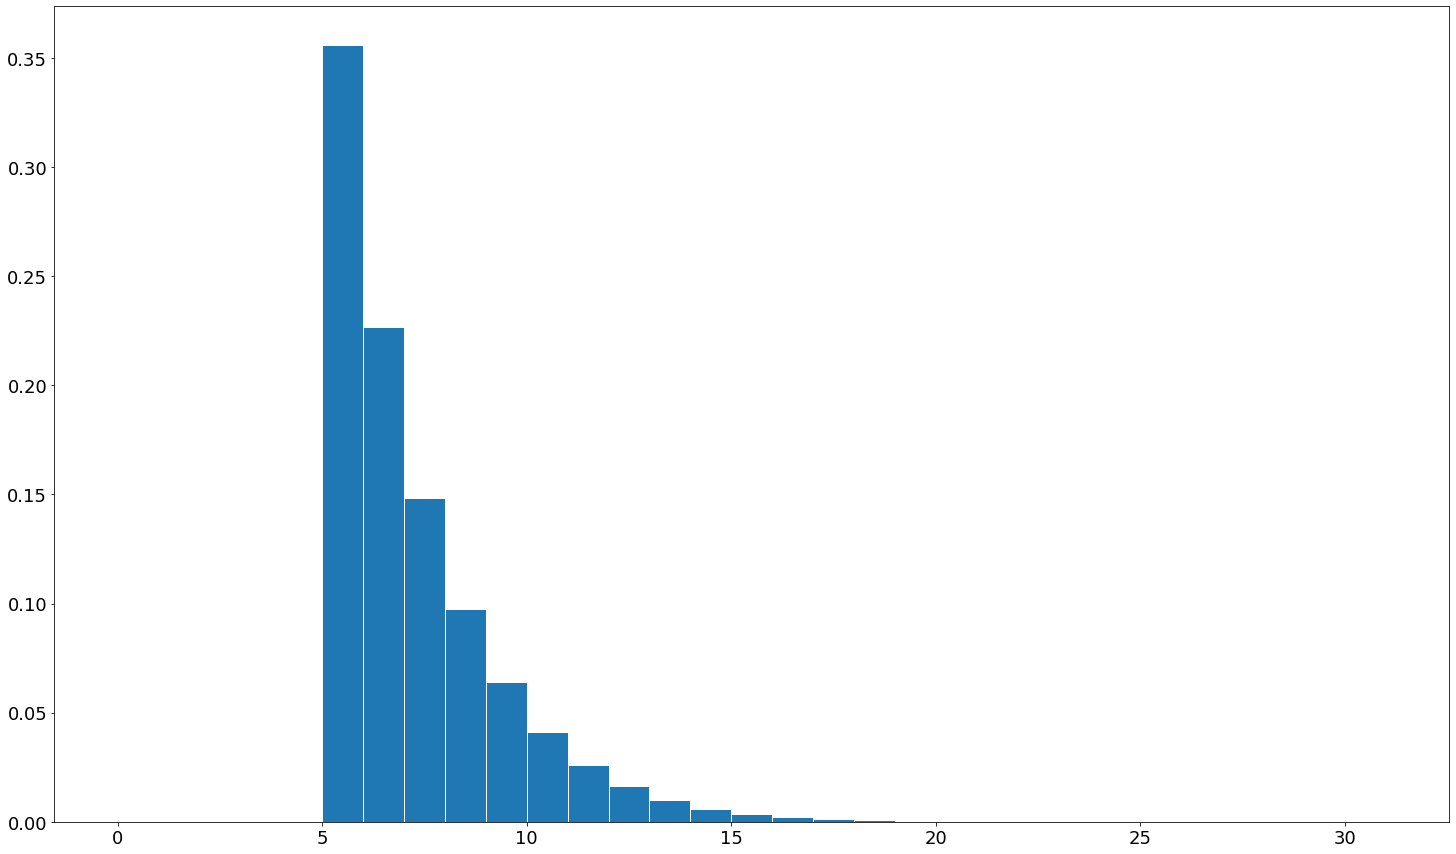

In [80]:
init = time.time()
skip_first_cols, n_inner_slices, n_outer_slices = 3, 12, 20

train_ar39 = undersample_argon(cutar39, round(len(aug_ar41_train))*1.5, augment_from_pe=15, augmentation_nr=10, skip_first_cols=skip_first_cols, nslices=n_inner_slices+n_outer_slices)
print(time.time() - init)

In [81]:
print("[Info] Training set: {} instances".format(len(aug_ar41_train) + len(train_ar39)))
print("\tAr41: {} instances ({:.2f}%)".format(len(aug_ar41_train), len(aug_ar41_train) / (len(aug_ar41_train)+len(train_ar39))))
print("\tAr39: {} instances ({:.2f}%)".format(len(train_ar39), len(train_ar39) / (len(aug_ar41_train)+len(train_ar39))))

[Info] Training set: 64754 instances
	Ar41: 25932 instances (0.40%)
	Ar39: 38822 instances (0.60%)


In [82]:
aug_ar41_train["y"] = 1
train_ar39["y"] = 0
all_train = pd.concat([aug_ar41_train, train_ar39])
X, y = all_train.iloc[:, :-1], all_train.iloc[:, -1]
X = X.to_numpy().reshape((X.shape[0], X.shape[1], 1))    # to consistency with NN input
print("[Safety Check] Training data: {} instances".format(X.shape[0]))

[Safety Check] Training data: 64754 instances


# training

In [17]:
import tensorflow as tf
import tensorflow.python.util.deprecation as deprecation
deprecation._PRINT_DEPRECATION_WARNINGS = False    # no deprecation warning print

import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score
from sklearn.metrics import roc_curve, plot_roc_curve
from sklearn.metrics import roc_auc_score

tf.test.is_gpu_available()

True

In [47]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, KFold
from tensorflow.keras.layers import Conv1D, Conv2D, MaxPooling1D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras import Sequential

In [19]:
def create_model(n_1_conv_layers=1, n_1_max_pooling_layers=1,
                 n_2_conv_layers=1, n_2_max_pooling_layers=1, n_3_dense_layers=1,
                 n_filters_1_conv_layers=64, kernel_size_1_conv_layers=6, activation_1_conv_layers='relu',
                 pool_size_1_max_pooling_layers=3,
                 n_filters_2_conv_layers=64, kernel_size_2_conv_layers=6, activation_2_conv_layers='relu',
                 pool_size_2_max_pooling_layers=3,
                 n_neurons_3_dense_layers=32, activation_3_dense_layers='relu',
                 activation_f_layer='sigmoid',
                 learningrate=0.01, decay=0.0, l1=0.01, l2=0.01, dropout=0.0,
                 input_shape=(32, 1), output_shape=1):
    print(".", end="")
    opt = tf.keras.optimizers.Adam(lr=learningrate, beta_1=0.9, beta_2=0.999,  decay=decay)
    reg = tf.keras.regularizers.l1_l2(l1=l1, l2=l2)
                                                     
    model = Sequential()
    
    first=True    # for the firt layer we need to specify the input dimensions
    for i in range(n_1_conv_layers):
        if first:
            model.add(Conv1D(filters=n_filters_1_conv_layers, kernel_size=kernel_size_1_conv_layers, 
                             activation=activation_1_conv_layers, input_shape=input_shape))
            first=False
        else: 
            model.add(Conv1D(filters=n_filters_1_conv_layers, kernel_size=kernel_size_1_conv_layers, 
                             activation=activation_1_conv_layers))
        if dropout>0:
            model.add(Dropout(dropout))
         
    for i in range(n_1_max_pooling_layers):
        model.add(MaxPooling1D(pool_size=pool_size_1_max_pooling_layers))
        if dropout>0:
            model.add(Dropout(dropout))
    
    for i in range(n_2_conv_layers):
        model.add(Conv1D(filters=n_filters_2_conv_layers, kernel_size=kernel_size_2_conv_layers, 
                         activation=activation_2_conv_layers))
        if dropout>0:
            model.add(Dropout(dropout))
          
    for i in range(n_2_max_pooling_layers):
        model.add(MaxPooling1D(pool_size=pool_size_2_max_pooling_layers))
        if dropout>0:
            model.add(Dropout(dropout))
    
    model.add(Flatten())
    
    previous_n_neurons = 2*n_neurons_3_dense_layers
    for i in range(n_3_dense_layers):        
        current_n_neurons = round(previous_n_neurons/2)
        model.add(Dense(current_n_neurons, activation=activation_3_dense_layers, kernel_regularizer=reg))
        previous_n_neurons = current_n_neurons
        if dropout>0:
            model.add(Dropout(dropout))
            
    model.add(Dense(output_shape, activation=activation_f_layer))
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=[tf.keras.metrics.AUC(), tf.keras.metrics.Precision()])
    return model

# hyperparams tuning

In [28]:
# numbers of layers
n_1_conv_layers = [1]    # 1. series of conv layers. here define the nr of conv layers
n_1_max_pooling_layers = [0, 1]     # 2. series of max pooling layers
n_2_conv_layers = [1, 2]       # 3. series of conv layers
n_2_max_pooling_layers = [1]     # 4. series of max pooling layers
n_3_dense_layers = [1, 2, 3]    

# layers' details 
n_filters_1_conv_layers = [64, 128, 256]
n_filters_2_conv_layers = [16, 32]
kernel_size_1_conv_layers = [6, 7, 8]
kernel_size_2_conv_layers = [2, 3, 4]
pool_size_1_max_pooling_layers = [2, 3]
pool_size_2_max_pooling_layers = [2, 3]
n_neurons_3_dense_layers = [16, 32, 64, 128]

# activation
activation_1_conv_layers = ['relu', 'sigmoid']
activation_2_conv_layers = ['relu', 'sigmoid']
activation_3_dense_layers = ['relu', 'sigmoid']
activation_f_layer = ['sigmoid']

# learning algorithm parameters
lr = [1e-1]
decay = [1e-6]

# dropout and regularisation
dropout = [0]
l1 = [0.0001]
l2 = [0.0001]

# dictionary summary
param_grid = dict(n_1_conv_layers=n_1_conv_layers, n_1_max_pooling_layers=n_1_max_pooling_layers,
                  n_2_conv_layers=n_2_conv_layers, n_2_max_pooling_layers=n_2_max_pooling_layers, n_3_dense_layers=n_3_dense_layers,
                  n_filters_1_conv_layers=n_filters_1_conv_layers, kernel_size_1_conv_layers=kernel_size_1_conv_layers, 
                  activation_1_conv_layers=activation_1_conv_layers,
                  pool_size_1_max_pooling_layers=pool_size_1_max_pooling_layers,
                  n_filters_2_conv_layers=n_filters_2_conv_layers, kernel_size_2_conv_layers=kernel_size_2_conv_layers, 
                  activation_2_conv_layers=activation_2_conv_layers,
                  pool_size_2_max_pooling_layers=pool_size_2_max_pooling_layers,
                  n_neurons_3_dense_layers=n_neurons_3_dense_layers, activation_3_dense_layers=activation_3_dense_layers,
                  activation_f_layer=activation_f_layer,
                  learningrate=lr, decay=decay, l1=l1, l2=l2, dropout=dropout)

In [29]:
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
# model class to use in the scikit random search CV 
n_epochs, batch_size = 3, 128
model = KerasClassifier(build_fn=create_model, epochs=n_epochs, batch_size=batch_size, verbose=0)

In [30]:
n_random_iterations=200
grid = RandomizedSearchCV(estimator=model, cv=KFold(3, shuffle=True), param_distributions=param_grid, scoring="roc_auc",
                          verbose=1,  n_iter=n_random_iterations, n_jobs=1)

In [31]:
print("[Info] Random Search CV")
print("\tNr Epochs: {}, Nr Random Iterations: {}".format(n_epochs, n_random_iterations))
init = time.time()
grid_result = grid.fit(X, y)
print("End in {:.3f} sec".format(time.time() - init))

[Info] Random Search CV
	Nr Epochs: 3, Nr Random Iterations: 200
Fitting 3 folds for each of 200 candidates, totalling 600 fits
.

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


.......................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed: 21.8min finished


.End in 1309.027 sec


In [32]:
grid_result.best_estimator_.get_params()

{'epochs': 3,
 'batch_size': 128,
 'verbose': 0,
 'pool_size_2_max_pooling_layers': 2,
 'pool_size_1_max_pooling_layers': 3,
 'n_neurons_3_dense_layers': 128,
 'n_filters_2_conv_layers': 32,
 'n_filters_1_conv_layers': 64,
 'n_3_dense_layers': 3,
 'n_2_max_pooling_layers': 1,
 'n_2_conv_layers': 1,
 'n_1_max_pooling_layers': 0,
 'n_1_conv_layers': 1,
 'learningrate': 0.1,
 'l2': 0.0001,
 'l1': 0.0001,
 'kernel_size_2_conv_layers': 3,
 'kernel_size_1_conv_layers': 8,
 'dropout': 0,
 'decay': 1e-06,
 'activation_f_layer': 'sigmoid',
 'activation_3_dense_layers': 'relu',
 'activation_2_conv_layers': 'relu',
 'activation_1_conv_layers': 'relu',
 'build_fn': <function __main__.create_model(n_1_conv_layers=1, n_1_max_pooling_layers=1, n_2_conv_layers=1, n_2_max_pooling_layers=1, n_3_dense_layers=1, n_filters_1_conv_layers=64, kernel_size_1_conv_layers=6, activation_1_conv_layers='relu', pool_size_1_max_pooling_layers=3, n_filters_2_conv_layers=64, kernel_size_2_conv_layers=6, activation_2_co

In [33]:
pd.DataFrame(grid_result.cv_results_).to_csv("new_tuning_cnn.txt")

In [34]:
grid_result.best_score_

0.9361929004032605

# try model wt conv 2d

In [70]:
def create_model2(n_filters_1_conv_layers, kernel_size_1_conv_layers, activation_1_conv_layers,
                  n_filters_2_conv_layers, kernel_size_2_conv_layers, activation_2_conv_layers,
                  pool_size_1_max_pooling_layers, pool_size_2_max_pooling_layers,
                  n_3_dense_layers, n_neurons_3_dense_layers, activation_3_dense_layers,
                  activation_f_layer,
                  learningrate, decay, dropout, l1, l2,
                  input_shape, output_shape):
    print(".", end="")
    opt = tf.keras.optimizers.Adam(lr=learningrate, beta_1=0.9, beta_2=0.999,  decay=decay)
    reg = tf.keras.regularizers.l1_l2(l1=l1, l2=l2)
                                                     
    model = Sequential()
    
    model.add(Conv1D(filters=n_filters_1_conv_layers, kernel_size=kernel_size_1_conv_layers, 
                             activation=activation_1_conv_layers, input_shape=input_shape))
    if dropout>0:
        model.add(Dropout(dropout))
         
    model.add(MaxPooling1D(pool_size=pool_size_1_max_pooling_layers))
    
    model.add(Conv1D(filters=n_filters_2_conv_layers, kernel_size=kernel_size_2_conv_layers, 
                     activation=activation_2_conv_layers))
    if dropout>0:
        model.add(Dropout(dropout))
          
    model.add(MaxPooling1D(pool_size=pool_size_2_max_pooling_layers))        
    model.add(Flatten())
    
    previous_n_neurons = 2*n_neurons_3_dense_layers
    for i in range(n_3_dense_layers):        
        current_n_neurons = round(previous_n_neurons/2)
        model.add(Dense(current_n_neurons, activation=activation_3_dense_layers, kernel_regularizer=reg))
        previous_n_neurons = current_n_neurons
        if dropout>0:
            model.add(Dropout(dropout))
            
    model.add(Dense(output_shape, activation=activation_f_layer))
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=[tf.keras.metrics.AUC(), tf.keras.metrics.Precision()])
    return model

In [84]:
m = create_model2(n_filters_1_conv_layers=128, kernel_size_1_conv_layers=10, activation_1_conv_layers="relu",
                  n_filters_2_conv_layers=64, kernel_size_2_conv_layers=5, activation_2_conv_layers="relu",
                  pool_size_1_max_pooling_layers=2, pool_size_2_max_pooling_layers=2, 
                  n_3_dense_layers=3, n_neurons_3_dense_layers=128, activation_3_dense_layers="relu",
                  learningrate=.01, decay=1e-6, activation_f_layer="sigmoid",
                  dropout=0.2, l1=.0001, l2=.0001,
                  input_shape=(32, 1), output_shape=1)

.

In [85]:
m.summary()

Model: "sequential_878"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_2189 (Conv1D)         (None, 23, 128)           1408      
_________________________________________________________________
dropout (Dropout)            (None, 23, 128)           0         
_________________________________________________________________
max_pooling1d_1314 (MaxPooli (None, 11, 128)           0         
_________________________________________________________________
conv1d_2190 (Conv1D)         (None, 7, 64)             41024     
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 64)             0         
_________________________________________________________________
max_pooling1d_1315 (MaxPooli (None, 3, 64)             0         
_________________________________________________________________
flatten_830 (Flatten)        (None, 192)            

In [86]:
results = m.fit(X, y, epochs=50)

Epoch 1/50
2024/2024 [==============================] - 11s 5ms/step - loss: 0.3750 - auc_830: 0.9212 - precision_830: 0.8848
Epoch 2/50
2024/2024 [==============================] - 11s 5ms/step - loss: 0.3573 - auc_830: 0.9282 - precision_830: 0.8911
Epoch 3/50
2024/2024 [==============================] - 11s 6ms/step - loss: 0.3493 - auc_830: 0.9302 - precision_830: 0.8945
Epoch 4/50
2024/2024 [==============================] - 11s 5ms/step - loss: 0.3361 - auc_830: 0.9315 - precision_830: 0.8906
Epoch 5/50
2024/2024 [==============================] - 11s 5ms/step - loss: 0.3465 - auc_830: 0.9308 - precision_830: 0.8953
Epoch 6/50
2024/2024 [==============================] - 11s 6ms/step - loss: 0.3461 - auc_830: 0.9304 - precision_830: 0.8884
Epoch 7/50
2024/2024 [==============================] - 11s 5ms/step - loss: 0.3421 - auc_830: 0.9314 - precision_830: 0.8887
Epoch 8/50
2024/2024 [==============================] - 11s 5ms/step - loss: 0.3284 - auc_830: 0.9343 - precision_830:

# test

In [95]:
# Compute features muon
import time

df_test_ar41_feat = pd.DataFrame(test_ar41.iloc[:, 3:].to_numpy())
df_test_1ar39_feat = pd.DataFrame(cutar39.iloc[:, 3:].to_numpy())

In [98]:
# create label
df_test_1ar39_feat["y"] = 0
df_test_ar41_feat["y"] = 1

# data preparation
all_test_data = pd.concat([df_test_1ar39_feat, df_test_ar41_feat], axis=0)
XX, yy = all_test_data.iloc[:, :-1], all_test_data.iloc[:, -1]
XX = XX.to_numpy().reshape((XX.shape[0], XX.shape[1], 1))    # to consistency with NN input

In [100]:
# inference
init = time.time()
y_pred_proba_cnn = m.predict_proba(XX)
print("[Info] Inference {} instances wt CNN: {:.3f} seconds".format(XX.shape[0], time.time()-init))

all_test_data["y_cnn"] = y_pred_proba_cnn

[Info] Inference 462641 instances wt CNN: 21.496 seconds


In [101]:
# plot roc curve
cnn_fpr, cnn_tpr, cnn_threshold = roc_curve(yy, all_test_data["y_cnn"])

[Info] CNN: Threshold: 0.50 => TPR: 0.732, FPR=0.023
[Info] CNN: Threshold: 0.75 => TPR: 0.640, FPR=0.006
[Info] CNN: Threshold: 0.85 => TPR: 0.621, FPR=0.003


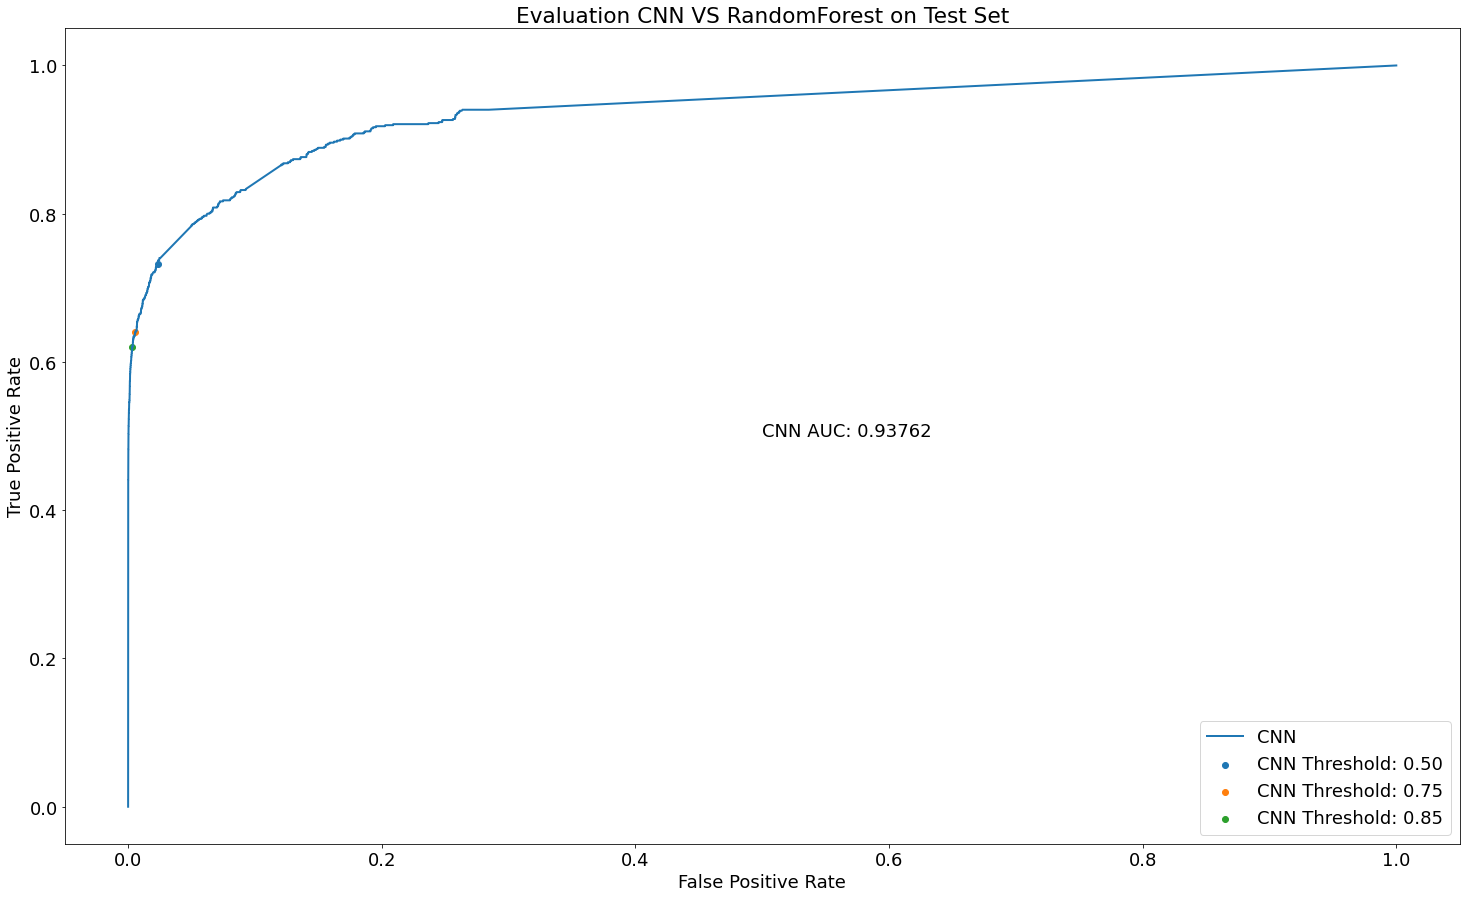

In [104]:
highlight_thresholds = [.50, .75, .85]

plt.plot(cnn_fpr, cnn_tpr, label="CNN", linewidth=2)
for threshold in highlight_thresholds:
    cnn_mid_threshold = np.argmin(abs(cnn_threshold-threshold))
    plt.scatter(cnn_fpr[cnn_mid_threshold], cnn_tpr[cnn_mid_threshold], label="CNN Threshold: {:.2f}".format(cnn_threshold[cnn_mid_threshold]))
    print("[Info] CNN: Threshold: {:.2f} => TPR: {:.3f}, FPR={:.3f}".format(cnn_threshold[cnn_mid_threshold], cnn_tpr[cnn_mid_threshold], cnn_fpr[cnn_mid_threshold]))

plt.text(.5, .5, "CNN AUC: {:.5f}".format(roc_auc_score(yy, all_test_data["y_cnn"])))

plt.title("Evaluation CNN VS RandomForest on Test Set")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()